# QOSF Task 2

Implement a circuit that returns $| 01 \rangle$ and $|10 \rangle$ with equal probability.

Requirements :
- The circuit should consist only of CNOTs, RXs and RYs. 
- Start from all parameters in parametric gates being equal to 0 or randomly chosen. 
- You should find the right set of parameters using gradient descent (you can use more advanced optimization methods if you like). 
- Simulations must be done with sampling - i.e. a limited number of measurements per iteration and noise. 

Compare the results for different numbers of measurements: 1, 10, 100, 1000. 

Bonus question:
How to make sure you produce state $|01 \rangle + |10 \rangle$ and not $|01 \rangle - |10 \rangle$?

In [2]:
# Importing necessary libraries 
# and predefining some variables
from qiskit import execute, Aer, QuantumCircuit 
from qiskit.visualization import plot_histogram, plot_state_qsphere as q_plot
from qiskit.quantum_info import Statevector
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

q_simulator = Aer.get_backend('qasm_simulator')
st_simulator = Aer.get_backend('statevector_simulator')

## Trial circuit
Let us implement a quantum circuit with known parameters that yields an equal probability of $| 01 \rangle$ and $| 10 \rangle$ to get an idea of what the gates the circuit must consist of.

In [6]:
# Define a quantum circuit consisting of 2 qubits
qc = QuantumCircuit(2)

# Hadamard gate on qubit 0
qc.ry(np.pi/2, 0)
qc.rx(np.pi, 0)

# X gate on qubit 1
qc.rx(np.pi, 1)

# CNOT gate with qubit 0, qubit 1 as the control and target qubits respectively
qc.cx(0,1)
qc.measure_all()

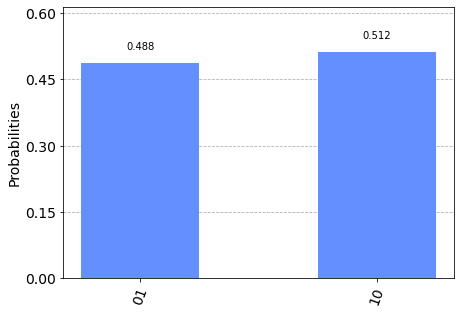

In [10]:
counts = execute(qc, q_simulator, shots=1000).result().get_counts()
plot_histogram(counts)

As can be seen from the histogram plot, we get the desired output. Our goal now is to parameterize the circuit by introducing unknown parameters to the RX and RY gates.

When trying to find the optimal solution to the parameterized problem, the CNOT gate does not play a role since it does not depend on parameters. Hence, the goal is to find the optimum solution to the state of the qubits just before applying the CNOT gate.

Let us see the effect of the gates used in the trial circuit to find the state of the system at the end of the circuit.

All qubits are initialized to the state $| 0 \rangle$ thus initializing the system at $| 00 \rangle$. Applying a Hadamard gate to the 1st qubit yields, 

$$ |00 \rangle \longrightarrow |0 \rangle \otimes \frac{1}{\sqrt{2}} (|0 \rangle + |1 \rangle)$$

It is a good point to note here that Qiskit orders its qubits in a different way compared to the textbook convention. In Qiskit, if $q_0$ and $q_1$ are the 1st and 2nd qubits respectively, then the composite system is written as

$$ |q_1 q_0 \rangle = |q_1 \rangle \otimes |q_0 \rangle$$

Now applying an X gate onto the second qubit,

$$ |0 \rangle \otimes \frac{1}{\sqrt{2}}(|0 \rangle + |1 \rangle) \longrightarrow |1 \rangle \otimes \frac{1}{\sqrt{2}} (|0 \rangle + |1 \rangle)$$

Finally applying a CNOT gate (with the first qubit as the control and the second qubit as the target), we get

$$ |1 \rangle \otimes \frac{1}{\sqrt{2}} (|0 \rangle + |1 \rangle) \longrightarrow \frac{1}{\sqrt{2}} (|10 \rangle + |01 \rangle) = |\psi \rangle$$

This final state $|\psi \rangle$ upon measurement, will yield $|10 \rangle$ with a probability of 0.5 and $|01 \rangle$ with a probability of 0.5.

However, since we are not concerned with unparameterized operations, we only have to worry about the state of the system just before the application of the CNOT gate. That state would be,

$$ |1 \rangle \otimes \frac{1}{\sqrt{2}}(|0 \rangle + |1 \rangle)$$

This state is clearly unentangled, meaning that the corresponding qubits are independent and that we can treat the problem as 2 separate optimization problems.

In [17]:
## Initializing parameters with random values

# q0_thetas holds parameters for the first qubit and q1_thetas holds parameters for the second qubit
q0_thetas = [ random.uniform(0.01, 2 * np.pi) for i in range(2)]
q1_thetas = [ random.uniform(0.01, 2 * np.pi) for i in range(2)]

Let us define a function that returns a parameterized quantum circuit

In [12]:
def circuit(params0, params1):
    circuit = QuantumCircuit(2)
    circuit.ry(params0[0], 0)
    circuit.rx(params0[1], 0)
    circuit.ry(params1[0], 1)
    circuit.rx(params1[1], 1)
    
    return circuit

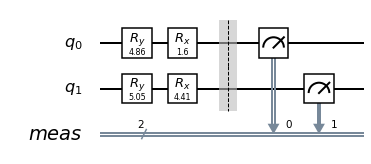

In [18]:
circ = circuit(q0_thetas, q1_thetas)
circ.measure_all()
circ.draw()